https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using 20x trained StarDist model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [2]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [4]:
import json
from stardist.models import Config2D

model = load_model(r"\\10.99.68.178\andreex\data\Stardist\PDAC model\models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0\offshoot_model_1_18_24")

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\PDAC model\models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0\offshoot_model_1_18_24\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.48631760224936815, nms=0.3) 


In [5]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

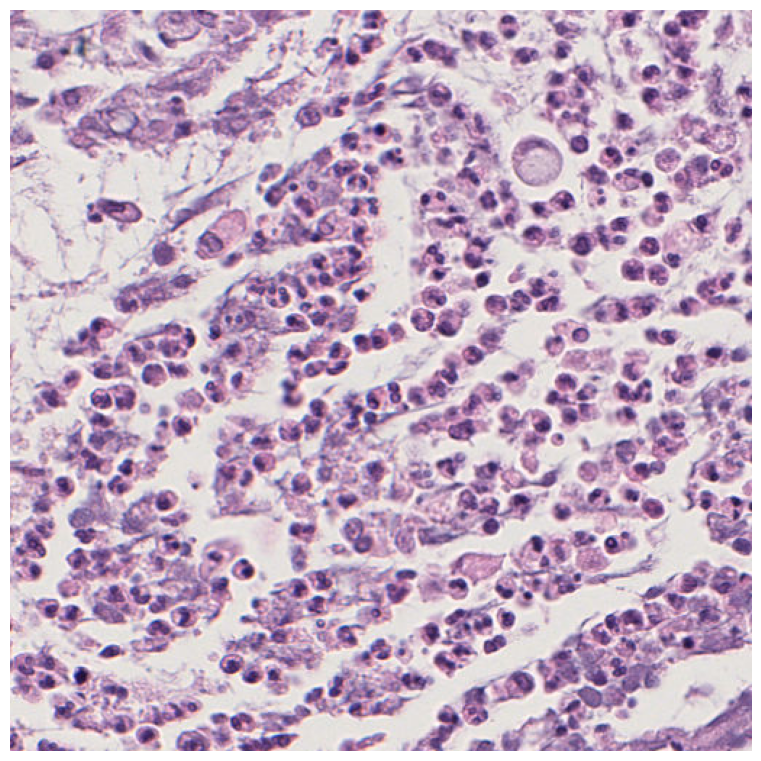

In [6]:
tiles_path = r'\\10.99.68.178\andreex\data\Stardist\PDAC model\training\20x_HE_tiles'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

ind = 0

tile = os.path.join(tiles_path, tiles[ind])
tile_im = imread(tile)

show_tile(tile_im)

In [7]:
full_tiles_path = []
for x in tiles:
    full_tiles_path.append(os.path.join(tiles_path, x))

full_tiles_path

['\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\20x_HE_tiles\\H15_0091.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\20x_HE_tiles\\H15_0151.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\20x_HE_tiles\\H15_0277_1.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\20x_HE_tiles\\H15_0421_1.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\20x_HE_tiles\\H15_0421_2.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\20x_HE_tiles\\PD.2 5N-T LCM.tif',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\20x_HE_tiles\\PD_25 3GG LCM1.tif']

In [8]:
from csbdeep.utils import Path, normalize
from stardist import fill_label_holes
from tqdm import tqdm  # progress bar class
from glob import glob

X = full_tiles_path
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

X = [x/255 for x in X]  # no norm, just divide by 255 to get into (0,1) range

Y_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X)]

100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


In [9]:
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

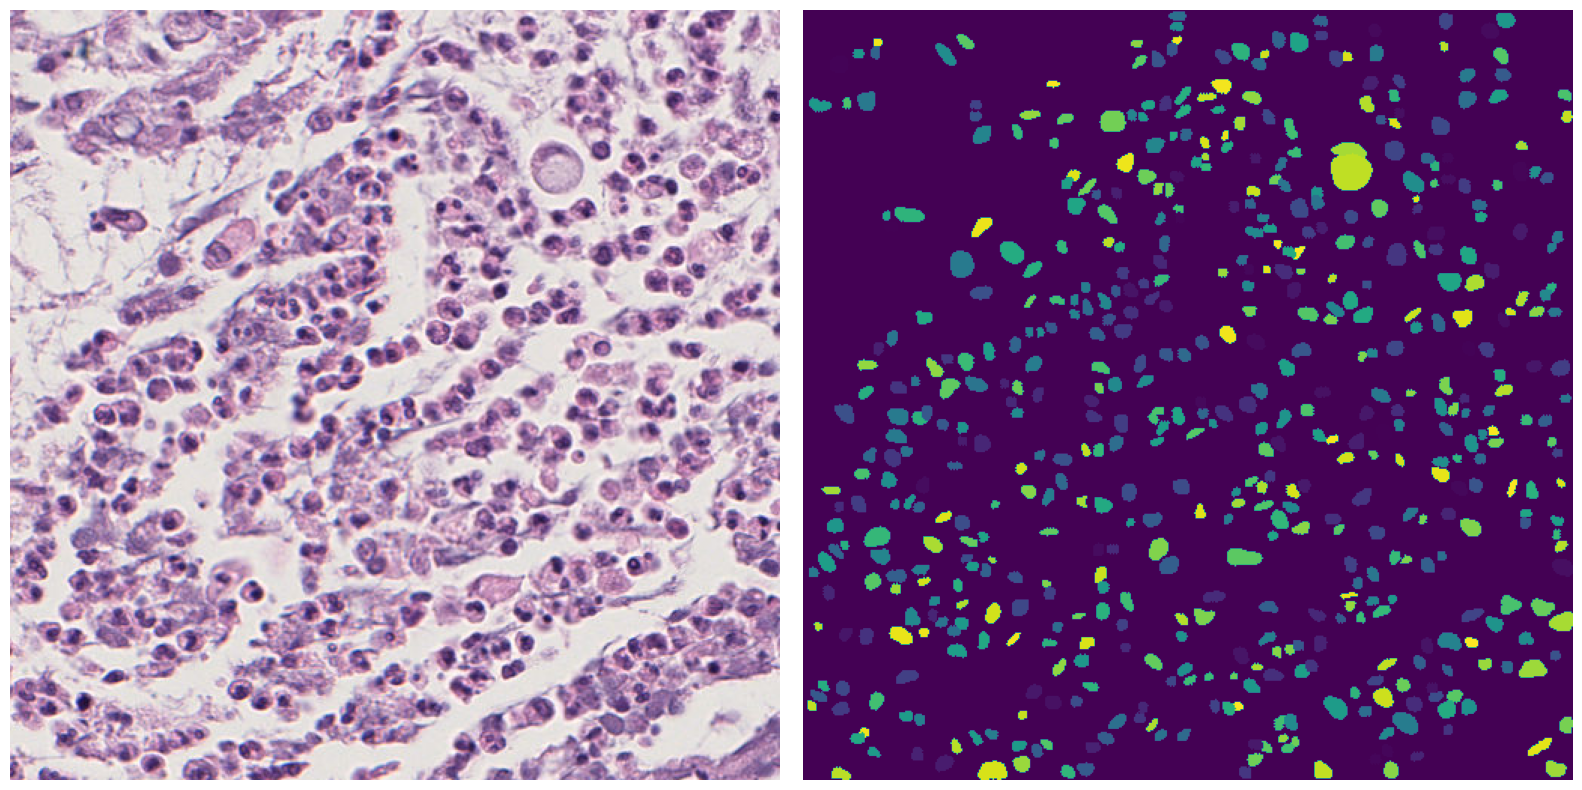

In [10]:
ind = 0

img = X[ind]
lbl = Y_pred[ind]

show_tile_segmented(img, lbl)

Now that we saw how it does on first tile, lets do it on all tiles and save

In [11]:
import json
import geojson
from pathlib import Path

# tiles_path = r'\\10.99.68.178\andreex\students\Vasco Fallopian tube\stardist\tiles512'
# correct format for geojson export file (centroids, contours, etc.)
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [12]:
# outpth = fr'{tiles_path}\stardist_segmented_jsons'
outpth = r'\\10.99.68.178\andreex\data\Stardist\PDAC model\training\temp'
if not os.path.exists(outpth):
    os.mkdir(outpth)

out_pth = Path(outpth)

tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

tile = os.path.join(tiles_path, tiles[ind])

for cc in range(len(tiles)):
    name = tiles[cc]
    tile_pth = os.path.join(tiles_path, name)
    tile = imread(tile_pth)

    tile = tile/255

    result = model.predict_instances(tile)

    # save centroids and contours in geojson format to import into qupath
    coords = result[1]['coord']
    # print(len(coords[0][0]))
    contours = []
    for xy in coords:
        contour = []
        for i in range(len(xy[0])):
            p = [xy[0][i], xy[1][i]]  # [x, y]
            contour.append(p)
        contours.append(contour)

    data_stardist = []
    for i in range(len(result[1]['points'])):
        nucleus = result[1]['points'][i]
        contour = contours[i]
        both = [nucleus, contour]
        data_stardist.append(both)

    GEOdata = []

    for centroid, contour in data_stardist:
        centroid = [centroid[0] + 0, centroid[1] + 0]
        # xy coordinates are swapped, so I reverse them here with xy[::-1]
        # note: add 1 to coords to fix 0 indexing vs 1 index offset
        contour = [[coord+0 for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
        contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

        # Create a new dictionary for each contour
        dict_data = {
            "type": "Feature",
            "id": "PathCellObject",
            "geometry": {
                "type": "Polygon",
                "coordinates": [contour]
            },
            "properties": {
                'objectType': 'annotation',
                'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
            }
        }

        GEOdata.append(dict_data)

    new_fn = name[:-4] + '.geojson'

    with open(out_pth.joinpath(new_fn),'w') as outfile:
        geojson.dump(GEOdata,outfile)
    print('Finished',new_fn)

    labels, polys = model.predict_instances(tile)
    # show_tile_segmented(tile, labels, cmap = cmap)


Finished H15_0091.geojson
Finished H15_0151.geojson
Finished H15_0277_1.geojson
Finished H15_0421_1.geojson
Finished H15_0421_2.geojson
Finished PD.2 5N-T LCM.geojson
Finished PD_25 3GG LCM1.geojson


In [13]:
outpth

'\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\training\\temp'